In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
#from google.colab import drive
import datetime
from datetime import timedelta
import time
import folium
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.geocoders import ArcGIS
import concurrent.futures
from geopy.distance import geodesic
from uszipcode import SearchEngine
from pandarallel import pandarallel
import pgeocode

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [28]:
#df = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Session-Details-Summary-20240605.csv')
df_tn_reg = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_EV_Registrations.csv')
df_venue= pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\lat_long_charging_venue.csv')
df_GIS= pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\rechargingstationproject\GIS_distance.xlsx', sheet_name='Total')
df_tn_population = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\tennessee_counties_population.csv')
df_tn_AADT = pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_AADT_TDOT.xlsx')
df_tn_MHHI_county = pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Median_H_H_Income.xlsx')
df_tn_TEMP_county = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\2023_TN_County_Average_Temperature.csv')
df_tn_Cooling_Degree_Days_county = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\2023_TN_County_Cooling_Degree_Days.csv')

In [54]:
df=pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Session-Details-Summary-20240605_with_distances.csv')


In [55]:
def mean_excluding_zeros(series):
    non_zero_values = series[series != 0]
    if len(non_zero_values) > 0:
        return np.mean(non_zero_values)
    else:
        return np.nan
#-----------------------------
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        if len(parts) >= 3:
            try:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(parts[2].split()[0])
                total_seconds = hours * 3600 + minutes * 60 + seconds
                return total_seconds
            except (IndexError, ValueError):
                print("Invalid duration format")
                return 0
        else:
            print("Invalid duration format")
            return 0
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0
#--------------------------------------------------------------------------------

def convert_to_est_old(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


time_zones = {
    'EST': 'America/New_York',
    'CST': 'America/Chicago',
    'CDT': 'America/Chicago',
    'EDT': 'America/New_York',
    'PDT': 'America/Los_Angeles',
    'PST': 'America/Los_Angeles'
}

# Convert time zones
def convert_to_est(row):
    est_tz = timezone('America/New_York')
    start_tz = timezone(time_zones[row['Start Time Zone']])
    end_tz = timezone(time_zones[row['End Time Zone']])

    row['Start Date'] = row['Start Date'].astimezone(start_tz).astimezone(est_tz)
    row['End Date'] = row['End Date'].astimezone(end_tz).astimezone(est_tz)

    return row

#--------------------------------------------------------------------------------

missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Apply function to Start and End Date
df['Start_Time_EST'] = pd.to_datetime(df['Start Date'])
df['End_Time_EST'] = pd.to_datetime(df['End Date'])


#sorting
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])


#    Total duration  Charging time   parking time   End charging Time

df['Total Duration'] = (df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
df['Charging Time'] = (df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600

df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']

df['parking_time'] = df['Total Duration'] - df['Charging Time']
df['End_Charging_Time_EST'] = [date + timedelta(hours=chargingtime) for date, chargingtime in df[['Start_Time_EST','Charging Time']].itertuples(index=False)]

# Data cleaning 
# sessions with delivered energy > 140 kWh, since these are incompatible with the usable battery capacities of the Rivian 
# R1T and extended-range Ford F-150 Lighting, the two mass-market EVs with the largest batteries available through March 2022;
# (2) sessions with a charge duration of 0 h or where no energy was delivered; 

df = df[(df['Energy (kWh)'] != 0) & (df['Energy (kWh)'] <= 140) & (df['Charging Time']!=0)]

In [56]:

# wich day of week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

# Peak hour 
# Add a new column 'peak_hour'
df['Start_Time_EST_Day'] = pd.to_datetime(df['Start_Time_EST']).dt.hour
df['peak_hour'] = ((df['Start_Time_EST_Day'] >= 6) & (df['Start_Time_EST_Day'] <= 20)).astype(int)


# Extract the month from 'Start Date'
df['month'] = pd.to_datetime(df['Start_Time_EST']).dt.month

def month_to_season(month):
    if month in [12, 1, 2]:
        return 4  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df['season'] = df['month'].apply(month_to_season)

# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)
df['Port Type'] = df['Port Type'].fillna('')

#Cost --> cost_free: Binary variable indicating if the station offers free charging
#     ---> cost_paid: Binary variable indicating if the station offers paid charging
df['Fee'] = df['Fee'].fillna(0)
df['cost_free'] = (df['Fee'] == 0).astype(int)
df['cost_paid'] = (df['Fee'] > 0).astype(int)


# If location of CS and driver are the same 

df['same_location'] = (df['Zip/Postal Code'] == df['Driver Zip/Postal Code']).astype(int)

# Add VENUE features

df['ven_leisure'] = (df['Charging Venue'] == 'Leisure').astype(int)
df['ven_med_ed'] = ((df['Charging Venue'] == 'Edu') | (df['Charging Venue'] == 'Medical' )).astype(int)
df['ven_HWY'] = (df['Charging Venue'] == 'HWY').astype(int)
df['ven_office'] = (df['Charging Venue'] == 'Office').astype(int)
df['ven_parking'] = (df['Charging Venue'] == 'Parking').astype(int)
df['ven_retail'] = (df['Charging Venue'] == 'Shopping').astype(int)
df['ven_Hotel'] = (df['Charging Venue'] == 'Hotel').astype(int)



#sorting data
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])

# idle time
#df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
#df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby(['EVSE ID','Port Number'])['End_Time_EST'].shift(1)
df['idle'] = df['Start_Time_EST'] - df['previous_end_time']
df['idle_hour']= (df['idle'].dt.total_seconds())/3600
df['idle_day']= (df['idle'].dt.total_seconds())/86400

# Calculate SOC difference
df['Start SOC'] = df['Start SOC'].str.replace('%', '').fillna(0).astype('int64')
df['End SOC'] = df['End SOC'].str.replace('%', '').fillna(0).astype('int64')
df['SOC_diff'] = df['End SOC'] - df['Start SOC']
mean_soc_diff_without_zeros = df[df['SOC_diff'] != 0]['SOC_diff'].mean()




#sorting df
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df.reset_index(drop=True, inplace=True)

####   Normalization based on service  #####
evse_service_time = df.groupby('EVSE ID').agg({'Start_Time_EST': 'min', 'End_Time_EST': 'max'})
evse_service_time['Service_Days'] = (evse_service_time['End_Time_EST'] - evse_service_time['Start_Time_EST']).dt.days
evse_service_time.reset_index(inplace=True)
df = pd.merge(df, evse_service_time[['EVSE ID', 'Service_Days']], on='EVSE ID', how='left')

df['Event Count'] = df.groupby('EVSE ID')['EVSE ID'].transform('count')
df['Normalized Event Count'] = df['Event Count'] / df['Service_Days']


###### Estimate of the rated power level for that EVSE port.
df['Power_Delivered'] = df['Energy (kWh)'] / df['Charging Time']
port_kw_estimate = df.groupby(['EVSE ID', 'Port Number'])['Power_Delivered'].mean().reset_index()
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')
df = df.drop(columns=['Power_Delivered_x'])
df = df.drop(columns=['Power_Delivered_y'])
port_kw_estimate = port_kw_estimate.rename(columns={'Power_Delivered': 'port_kw'})
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')




#---------------------------------------------------------------------------------------------------------------------
###  Utilizatiion Rate   ####
unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique()
total_charging_time_evse=df.groupby('EVSE ID')['Charging Time'].sum()

utilization_data = pd.DataFrame({
    'EVSE ID': unique_ports_per_evse.index,
    'Number of Ports': unique_ports_per_evse.values,
    'Total Charging Time (hours)': total_charging_time_evse,
    'Service Days': df.groupby('EVSE ID')['Service_Days'].max()

})

#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
utilization_data['Total Available Time (hours)'] = utilization_data['Number of Ports'] * utilization_data['Service Days'] * 24

# Calculate the utilization rate
utilization_data['Utilization Rate'] = utilization_data['Total Charging Time (hours)'] / utilization_data['Total Available Time (hours)']

#---------------------------------------------------------------------------------------------------------------------
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
####   DC and L2 df  ####
#df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
#df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]

# TN State
#df_TN=df[df['State/Province']=='Tennessee']



In [57]:
df = df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Date'] = df['Start_Time_EST'].dt.date

# 2023 and TN State 
df_tennessee_2023 = df[(df['State/Province'] == 'Tennessee') & (df['Port Type'] == 'Level 2')]
# Level 2    DC Fast

unique_ports_per_evse = df_tennessee_2023.groupby('EVSE ID')['Port Number'].nunique().reset_index()
daily_usage_evse = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Energy (kWh)'].sum().reset_index()
daily_charging_time_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Charging Time'].sum().reset_index()
daily_fee_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Fee'].sum().reset_index()
daily_port_rated=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['port_kw'].mean().reset_index()
zip_code_estimate = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Distance (miles)'].mean().reset_index()
season_df = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['season'].mean().reset_index()
peak_hour_df = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['peak_hour'].sum().reset_index()
GHG_saving = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['GHG Savings (kg)'].sum().reset_index()
gasoline_saving = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Gasoline Savings (gallons)'].sum().reset_index()


# Calculate the number of charging events per day per EVSE ID 
daily_events = df_tennessee_2023.groupby(['EVSE ID', 'Date']).size().reset_index()
daily_events.columns = ['EVSE ID', 'Date', 'Number of Events']

#   Average daily basis in kilowatt-hours per port per day   
#   Create utilization_station_data DataFrame
utilization_station_data = pd.merge(unique_ports_per_evse, daily_usage_evse, on='EVSE ID', how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_events, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_charging_time_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_fee_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_port_rated, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, zip_code_estimate, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, season_df, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, peak_hour_df, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, GHG_saving, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, gasoline_saving, on=['EVSE ID', 'Date'], how='left')


# Create new columns 'Is_Weekday' and 'Is_Weekend'
utilization_station_data['Day_of_Week'] = pd.to_datetime(utilization_station_data['Date']).dt.dayofweek
utilization_station_data['Is_Weekday'] = utilization_station_data['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
utilization_station_data['Is_Weekend'] = utilization_station_data['Day_of_Week'].isin([5, 6]).astype(int)




merged_df = df[['EVSE ID', 'Charging Venue', 'City', 'Station Name', 'Address 1', 'State/Province', 'County',
                     'Zip/Postal Code', 'Latitude (y)', 'Longitude (x)', 'Port Type']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df, on='EVSE ID', how='left')

merged_df_GIS = df_GIS[['County', 'County_population_2021']].drop_duplicates()
                         #'Grocery_Label', 'HighwayInterstate_Dis', 'HighwayInterstate_Name', 'HWY_Label', 'Hotels_Dis', 'Hotels_Name', 
                        # 'Hotel_Label', 'Parks_Dis', 'Parks_Name', 'Park_Label',
                        # 'Comprehensive_Dis', 'Comprehencive_Name', 'Comp_Label', 'Weight']].drop_duplicates()

utilization_station_data = pd.merge(utilization_station_data, merged_df_GIS, on='County', how='left')


# Add EV for TN 
tn_ev_county= df_tn_reg.groupby(['County'])['Vehicle Count'].sum().reset_index()
utilization_station_data = pd.merge(utilization_station_data, tn_ev_county, on='County', how='left')
utilization_station_data['percentage of poulation']=(utilization_station_data['Vehicle Count']*100)/utilization_station_data['County_population_2021']
utilization_station_data.dropna(subset=['percentage of poulation'], inplace=True)


# Normalized Event count 
merged_df_normalized =  df_tennessee_2023[['EVSE ID', 'Normalized Event Count']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df_normalized, on='EVSE ID', how='left')



#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
merged_df_utilization_rate = utilization_data[['EVSE ID', 'Number of Ports', 'Utilization Rate']].drop_duplicates().reset_index(drop=True)
utilization_station_data = pd.merge(utilization_station_data, merged_df_utilization_rate, on='EVSE ID', how='left')


# Estimate of the rated power level for that EVSE port.
df['Power_Delivered'] = df['Energy (kWh)'] / df['Charging Time']

port_kw_estimate = df.groupby(['EVSE ID', 'Port Number'])['Power_Delivered'].max().reset_index()

# Rename the column to 'port_kw'
port_kw_estimate = port_kw_estimate.rename(columns={'Power_Delivered': 'port_kw'})

# Merge the estimated port_kw back into the original DataFrame
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')



# Traffic data aggregation
traffic_data = df_tn_AADT.groupby('County').agg({
    'Vehicle_Miles_traveled_Passenger': 'sum', 
    'Vehicle_Passenger_Number': 'sum'
})

utilization_station_data = pd.merge(utilization_station_data, traffic_data, on='County', how='inner')

# Median household income data aggregation
df_MHHI = df_tn_MHHI_county.groupby('County').agg({
    'MED_HH_INCOME': 'mean'
})

utilization_station_data = pd.merge(utilization_station_data, df_MHHI, on='County', how='inner')


#Weather 
df_tn_TEMP_county = df_tn_TEMP_county[['County', 'Temp']]
utilization_station_data = pd.merge(utilization_station_data, df_tn_TEMP_county, on='County', how='inner')
utilization_station_data = pd.merge(utilization_station_data, df_tn_Cooling_Degree_Days_county, on='County', how='inner')


# Station utilization  (kWh/port/day)
# station utilization as the average energy delivered by a station during a time period divided by the number of ports.

utilization_station_data['Util_station (kWh/port/day)'] = utilization_station_data['Energy (kWh)']/ utilization_station_data['Port Number']
utilization_station_data['Fee_station (Dollar/port/day)'] = utilization_station_data['Fee']/ utilization_station_data['Port Number']
utilization_station_data['Unit_price'] = utilization_station_data['Fee_station (Dollar/port/day)']*100/ utilization_station_data['Util_station (kWh/port/day)']

#Venue
utilization_station_data['ven_hotel'] = (utilization_station_data['Charging Venue'] == 'Hotel').astype(int)
utilization_station_data['ven_leisure'] = (utilization_station_data['Charging Venue'] == 'Leisure').astype(int)
utilization_station_data['ven_med_ed'] = ((utilization_station_data['Charging Venue'] == 'Medical') | (utilization_station_data['Charging Venue'] == 'Edu' )).astype(int)
utilization_station_data['ven_HWY'] = (utilization_station_data['Charging Venue'] == 'HWY').astype(int)
utilization_station_data['ven_office'] = (utilization_station_data['Charging Venue'] == 'Office').astype(int)
utilization_station_data['ven_parking'] = (utilization_station_data['Charging Venue'] == 'Parking').astype(int)
utilization_station_data['ven_retail'] = (utilization_station_data['Charging Venue'] == 'Shopping').astype(int)


# CDC or L2

utilization_station_data['DC'] = (utilization_station_data['Port Type'] == 'DC Fast').astype(int)
utilization_station_data['L2'] = (utilization_station_data['Port Type'] == 'Level 2').astype(int)

# Cost free or paid
utilization_station_data['cost_free'] = (utilization_station_data['Fee'] == 0).astype(int)
utilization_station_data['cost_paid'] = (utilization_station_data['Fee'] > 0).astype(int)




# Unit price 
utilization_station_data['Energy_Unit_Price']=utilization_station_data['Fee']/utilization_station_data['Util_station (kWh/port/day)']


In [58]:
utilization_station_data['Port Type']

0       Level 2
1       Level 2
2       Level 2
3       Level 2
4       Level 2
5       Level 2
6       Level 2
7       Level 2
8       Level 2
9       Level 2
10      Level 2
11      Level 2
12      Level 2
13      Level 2
14      Level 2
15      Level 2
16      Level 2
17      Level 2
18      Level 2
19      Level 2
20      Level 2
21      Level 2
22      Level 2
23      Level 2
24      Level 2
25      Level 2
26      Level 2
27      Level 2
28      Level 2
29      Level 2
30      Level 2
31      Level 2
32      Level 2
33      Level 2
34      Level 2
35      Level 2
36      Level 2
37      Level 2
38      Level 2
39      Level 2
40      Level 2
41      Level 2
42      Level 2
43      Level 2
44      Level 2
45      Level 2
46      Level 2
47      Level 2
48      Level 2
49      Level 2
50      Level 2
51      Level 2
52      Level 2
53      Level 2
54      Level 2
55      Level 2
56      Level 2
57      Level 2
58      Level 2
59      Level 2
60      Level 2
61      Level 2
62      

# Perform OLS regression DC only 

In [59]:

independent_vars = ['Energy_Unit_Price','port_kw','Distance (miles)','season','peak_hour','Temp','Fahrenheit_Degree_Days',
                    'Day_of_Week', 'Is_Weekday', 'Is_Weekend', 'ven_HWY','ven_hotel','ven_med_ed',
                    'ven_leisure',  'percentage of poulation', 
                    'ven_office', 
                    'cost_free', 'cost_paid', 'Utilization Rate',   
                    'Vehicle_Miles_traveled_Passenger',
                    'Vehicle_Passenger_Number','MED_HH_INCOME',
                     'County_population_2021']

X = utilization_station_data[independent_vars]
Y = utilization_station_data['Util_station (kWh/port/day)']

# Check for infinity and NaN
is_infinite = np.isinf(X).any()
print("Infinite values in independent variables:")
print(is_infinite)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))


X.reset_index(drop=True, inplace=True)
Y = Y.iloc[X.index]
Y.reset_index(drop=True, inplace=True)

Infinite values in independent variables:
Energy_Unit_Price                   False
port_kw                             False
Distance (miles)                    False
season                              False
peak_hour                           False
Temp                                False
Fahrenheit_Degree_Days              False
Day_of_Week                         False
Is_Weekday                          False
Is_Weekend                          False
ven_HWY                             False
ven_hotel                           False
ven_med_ed                          False
ven_leisure                         False
percentage of poulation             False
ven_office                          False
cost_free                           False
cost_paid                           False
Utilization Rate                     True
Vehicle_Miles_traveled_Passenger    False
Vehicle_Passenger_Number            False
MED_HH_INCOME                       False
County_population_2021            

In [60]:
# Double-check lengths of X and Y
print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))

# Verify index ranges
print("Index range of X:", X.index.min(), "-", X.index.max())
print("Index range of Y:", Y.index.min(), "-", Y.index.max())

# Check if X's indices are within the range of Y's indices
if X.index.max() > Y.index.max() or X.index.min() < Y.index.min():
    print("Indices of X are out of range for Y")

# Check if Y's indices are within the range of X's indices
if Y.index.max() > X.index.max() or Y.index.min() < X.index.min():
    print("Indices of Y are out of range for X")

Number of samples in X: 8167
Number of samples in Y: 8167
Index range of X: 0 - 8166
Index range of Y: 0 - 8166


In [61]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Perform permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Get the feature importances
importances = result.importances_mean

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

Mean Squared Error: 70.07298146928531
R-squared: 0.4920979245960564
   Feature                            Importance
4                          peak_hour  0.363781  
0                  Energy_Unit_Price  0.214890  
1                            port_kw  0.201462  
2                   Distance (miles)  0.133497  
6             Fahrenheit_Degree_Days  0.093936  
18                  Utilization Rate  0.064456  
22            County_population_2021  0.044403  
7                        Day_of_Week  0.019506  
3                             season  0.016749  
5                               Temp  0.013279  
14           percentage of poulation  0.006589  
20          Vehicle_Passenger_Number  0.006044  
16                         cost_free  0.005921  
13                       ven_leisure  0.004781  
21                     MED_HH_INCOME  0.003606  
17                         cost_paid  0.002547  
19  Vehicle_Miles_traveled_Passenger  0.001478  
15                        ven_office  0.000637  
1

In [62]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pandas as pd

# Adjust display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'left')

# Assuming X and Y are already defined
# K-Fold cross-validation
model_LR = LinearRegression()
scores = cross_val_score(model_LR, X, Y, cv=5)
print("Cross-validation scores (Linear Regression): ", scores)
print("Average cross-validation score (Linear Regression): ", np.mean(scores))

# Splitting the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)
print("Testing set:", X_test.shape, Y_test.shape)

# Adding a constant term to the predictors for the intercept
X_train_const = sm.add_constant(X_train)
X_val_const = sm.add_constant(X_val)
X_test_const = sm.add_constant(X_test)

# Fit the OLS regression model on the training data
model_ols = sm.OLS(Y_train, X_train_const).fit()
ols_summary = model_ols.summary()

# Print the summary to console
print(ols_summary)

# Alternatively, write the summary to a text file for full viewing
with open('ols_Level2_summary.txt', 'w') as f:
    f.write(ols_summary.as_text())

# Calculate the validation score (R-squared)
Y_val_pred = model_ols.predict(X_val_const)
val_score = r2_score(Y_val, Y_val_pred)
print("Validation R^2 score (OLS): ", val_score)

# Calculate the test score (R-squared)
Y_test_pred = model_ols.predict(X_test_const)
test_score = r2_score(Y_test, Y_test_pred)
print("Test R^2 score (OLS): ", test_score)


Cross-validation scores (Linear Regression):  [-10.78044155   0.18518513  -0.88824185  -0.25066995  -0.54964894]
Average cross-validation score (Linear Regression):  -2.456763431989592
Training set: (5716, 23) (5716,)
Validation set: (1225, 23) (1225,)
Testing set: (1226, 23) (1226,)
                                 OLS Regression Results                                
Dep. Variable:     Util_station (kWh/port/day)   R-squared:                       0.275
Model:                                     OLS   Adj. R-squared:                  0.273
Method:                          Least Squares   F-statistic:                     103.1
Date:                         Wed, 03 Jul 2024   Prob (F-statistic):               0.00
Time:                                 21:59:44   Log-Likelihood:                -21404.
No. Observations:                         5716   AIC:                         4.285e+04
Df Residuals:                             5694   BIC:                         4.300e+04
Df Model:  

In [63]:
print(model_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:     Util_station (kWh/port/day)   R-squared:                       0.275
Model:                                     OLS   Adj. R-squared:                  0.273
Method:                          Least Squares   F-statistic:                     103.1
Date:                         Wed, 03 Jul 2024   Prob (F-statistic):               0.00
Time:                                 21:59:49   Log-Likelihood:                -21404.
No. Observations:                         5716   AIC:                         4.285e+04
Df Residuals:                             5694   BIC:                         4.300e+04
Df Model:                                   21                                         
Covariance Type:                     nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [73]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pandas as pd

# Adjust display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'left')

# Assuming X and Y are already defined

# K-Fold cross-validation
model_LR = LinearRegression()
scores = cross_val_score(model_LR, X, Y, cv=5)
print("Cross-validation scores (Linear Regression): ", scores)
print("Average cross-validation score (Linear Regression): ", np.mean(scores))

# Splitting the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)
print("Testing set:", X_test.shape, Y_test.shape)

# Adding a constant term to the predictors for the intercept
X_train_const = sm.add_constant(X_train)
X_val_const = sm.add_constant(X_val)
X_test_const = sm.add_constant(X_test)

# Fit the OLS regression model on the training data
model_ols = sm.OLS(Y_train, X_train_const).fit()

# Print the hyperparameters
print("Hyperparameters:")
print("Intercept:", model_ols.params[0])
print("Coefficients:", model_ols.params[1:])
print("P-values:", model_ols.pvalues)
print("R-squared:", model_ols.rsquared)
print("Adjusted R-squared:", model_ols.rsquared_adj)

ols_summary = model_ols.summary()
# Print the summary to console
print(ols_summary)

# Alternatively, write the summary to a text file for full viewing
with open('ols_Level2_summary.txt', 'w') as f:
    f.write(ols_summary.as_text())

# Calculate the validation score (R-squared)
Y_val_pred = model_ols.predict(X_val_const)
val_score = r2_score(Y_val, Y_val_pred)
print("Validation R^2 score (OLS): ", val_score)

# Calculate the test score (R-squared)
Y_test_pred = model_ols.predict(X_test_const)
test_score = r2_score(Y_test, Y_test_pred)
print("Test R^2 score (OLS): ", test_score)

Cross-validation scores (Linear Regression):  [-10.78044155   0.18518513  -0.88824185  -0.25066995  -0.54964894]
Average cross-validation score (Linear Regression):  -2.456763431989592
Training set: (5716, 23) (5716,)
Validation set: (1225, 23) (1225,)
Testing set: (1226, 23) (1226,)
Hyperparameters:
Intercept: 261.28284793220047
Coefficients: Energy_Unit_Price                  -1.131305e-01
port_kw                             1.196064e-01
Distance (miles)                   -6.848201e-04
season                             -4.766318e-01
peak_hour                           5.137130e+00
Temp                               -1.080461e+01
Fahrenheit_Degree_Days              7.195374e-02
Day_of_Week                         2.130729e-01
Is_Weekday                          1.306543e+02
Is_Weekend                          1.306285e+02
ven_HWY                             1.979797e+00
ven_hotel                          -2.478017e+01
ven_med_ed                          8.978538e-01
ven_leisure      

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29152\993250152.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Intercept:", model_ols.params[0])


In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize the decision tree regressor
model_DT = DecisionTreeRegressor(random_state=42)

# Train the model
model_DT.fit(X_train, Y_train)

# Make predictions
Y_pred = model_DT.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 7.2947681441484535
Mean Squared Error: 134.83178442867737
R-squared: 0.04212521442687678


# RF Hyperparameters

High multicollinearity can be a problem because it can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret.
You might want to consider dropping or transforming some of these variables to address the multicollinearity issue. For example, you could use Principal Component Analysis (PCA) to reduce the dimensionality of your dataset, or you could remove some of the highly correlated variables. You could also consider using regularization techniques like Ridge or Lasso regression which can help in handling multicollinearity.


Correlations with the dependent variable:
Energy_Unit_Price                  -0.012673
port_kw                             0.116949
Distance (miles)                    0.007132
season                             -0.058568
peak_hour                           0.368972
Temp                               -0.042576
Fahrenheit_Degree_Days             -0.033628
Day_of_Week                         0.025275
Is_Weekday                         -0.011049
Is_Weekend                          0.011049
ven_HWY                            -0.091043
ven_hotel                          -0.074338
ven_med_ed                         -0.076652
ven_leisure                         0.190303
percentage of poulation            -0.026491
ven_office                         -0.124156
cost_free                          -0.078242
cost_paid                           0.078242
Utilization Rate                    0.224647
Vehicle_Miles_traveled_Passenger   -0.035216
Vehicle_Passenger_Number           -0.061208
MED_HH_INCOM

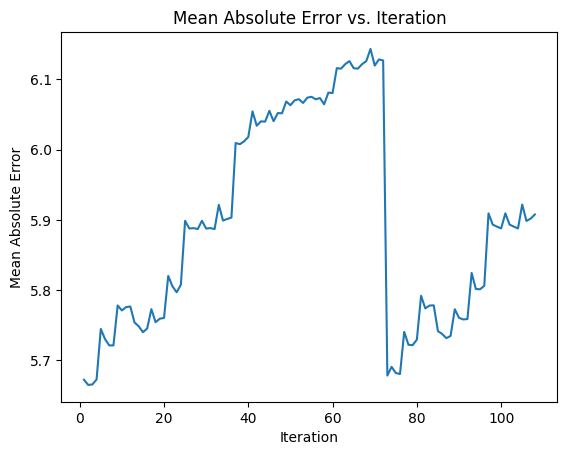


Mean MAE: 5.8912 (+/- 0.1474)
Mean R^2: 0.4759 (+/- 0.0103)
Test MAE: 5.7484
Test R^2: 0.4972


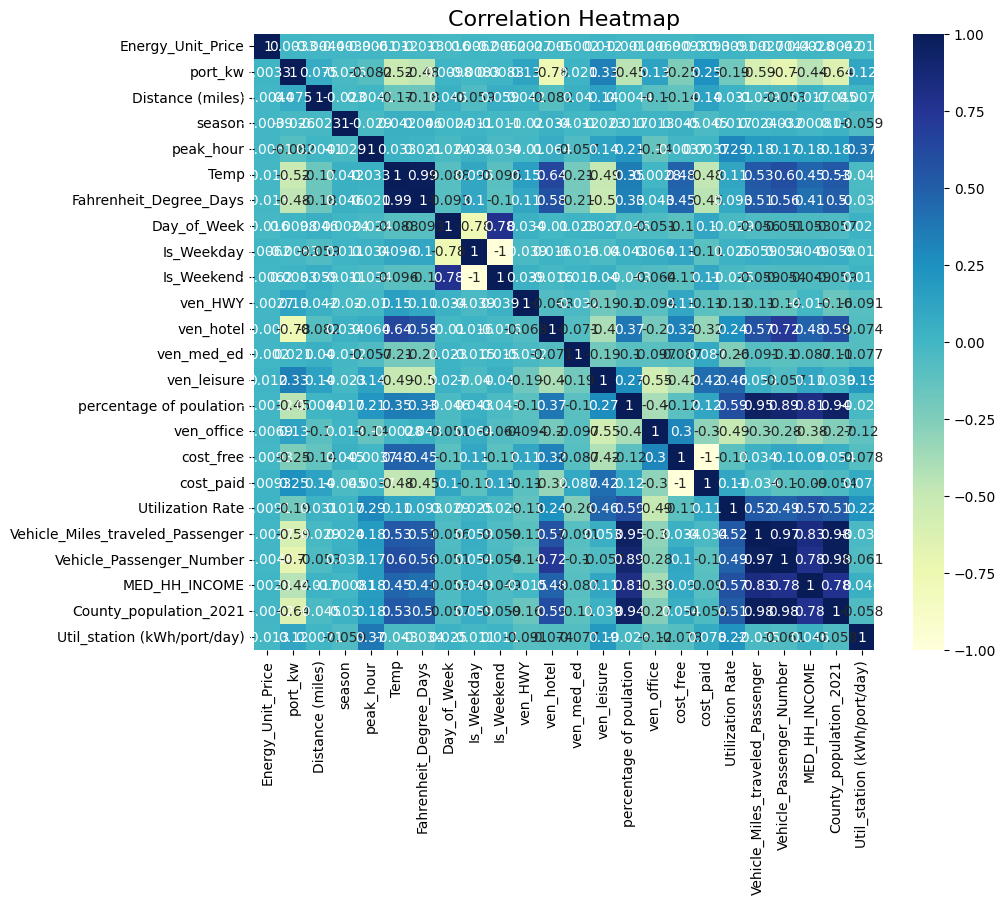

In [71]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Calculate the Pearson correlation coefficients
corr_matrix = X.join(Y).corr()
corr_with_target = corr_matrix[Y.name]

# Print the correlation coefficients with the dependent variable
print("\nCorrelations with the dependent variable:")
print(corr_with_target)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
Y_val_pred = rf_model.predict(X_val)
val_score_rf = r2_score(Y_val, Y_val_pred)
print("Validation R^2 score (Random Forest):", val_score_rf)

Y_test_pred = rf_model.predict(X_test)
test_score_rf = r2_score(Y_test, Y_test_pred)
print("Test R^2 score (Random Forest):", test_score_rf)




param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)



mae_values = []
train_scores = []
test_scores = []
r2_scores = []  # Initialize r2_scores list

# Perform cross-validation to get MAE, training, and testing scores after each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    if params['max_features'] != 'auto':  # Check if 'max_features' is set to 'auto'
        rf = RandomForestRegressor(**params, random_state=42)
        rf.fit(X_train, Y_train)

        # Calculate MAE
        Y_pred = rf.predict(X_test)
        mae = mean_absolute_error(Y_test, Y_pred)
        mae_values.append(mae)

        # Calculate R-squared scores for training and testing sets
        train_score = rf.score(X_train, Y_train)
        test_score = rf.score(X_test, Y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)

        # Calculate R-squared score for validation set
        r2_score_val = r2_score(Y_val, rf.predict(X_val))
        r2_scores.append(r2_score_val)

        print(f"Iteration {i+1}: MAE = {mae}, Train Score = {train_score}, Test Score = {test_score}, Val Score = {r2_score_val}")
    else:
        print(f"Iteration {i+1}: 'max_features' is set to 'auto', skipping...")


# Plot MAE values
plt.plot(range(1, len(mae_values) + 1), mae_values, marker='', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Iteration')
plt.show()

from sklearn.metrics import r2_score
# Calculate the mean and standard deviation of MAE and R^2
mae_mean = np.mean(mae_values)
mae_std = np.std(mae_values)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
print(f"\nMean MAE: {mae_mean:.4f} (+/- {mae_std:.4f})")
print(f"Mean R^2: {r2_mean:.4f} (+/- {r2_std:.4f})")

# Make predictions on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}") 
print(f"Test R^2: {test_r2:.4f}")

# Create a heatmap visualization for correlation 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [72]:
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


Correlations with the dependent variable (Level2):
Energy_Unit_Price                  -0.012673
port_kw                             0.116949
Distance (miles)                    0.007132
season                             -0.058568
peak_hour                           0.368972
Temp                               -0.042576
Fahrenheit_Degree_Days             -0.033628
Day_of_Week                         0.025275
Is_Weekday                         -0.011049
Is_Weekend                          0.011049
ven_HWY                            -0.091043
ven_hotel                          -0.074338
ven_med_ed                         -0.076652
ven_leisure                         0.190303
percentage of poulation            -0.026491
ven_office                         -0.124156
cost_free                          -0.078242
cost_paid                           0.078242
Utilization Rate                    0.224647
Vehicle_Miles_traveled_Passenger   -0.035216
Vehicle_Passenger_Number           -0.061208
MED_

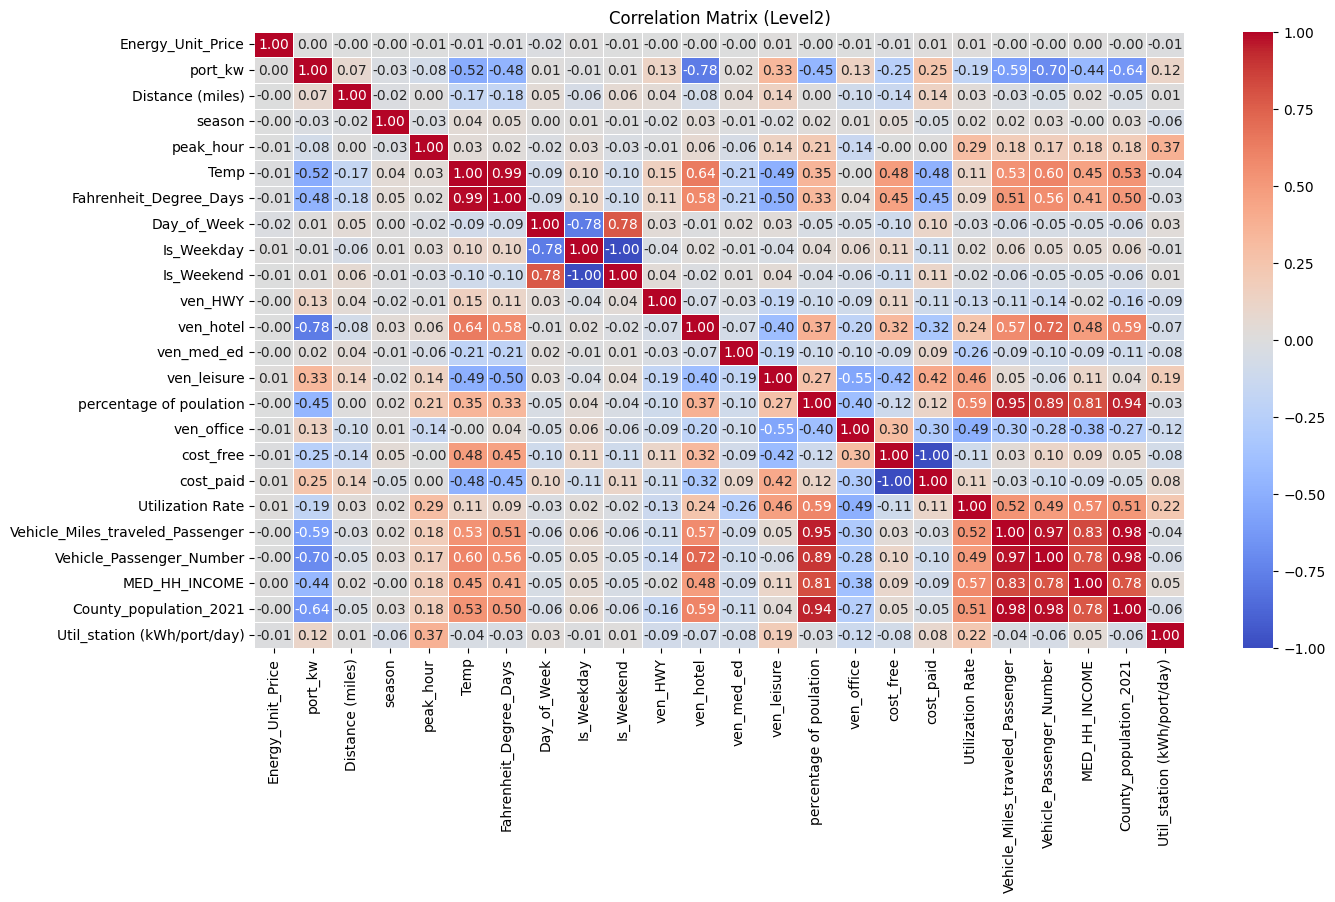

In [66]:
# Combine independent variables and dependent variable into one DataFrame
df_combined = pd.concat([X, Y], axis=1)

# Calculate correlations
correlations = df_combined.corr()

# Extract correlation values with the dependent variable
corr_with_dependent = correlations.iloc[:-1, -1]

# Print correlations with the dependent variable
print("Correlations with the dependent variable (Level2):")
print(corr_with_dependent)

# Calculate Pearson correlation coefficient
pearson_coefficient = df_combined.corr().iloc[:-1, -1].values[0]

print("Pearson correlation coefficient:", pearson_coefficient)

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
correlations = df_combined.corr()

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Level2)')
plt.show()

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.8}
Test MAE: 5.5888
Test R^2: 0.5182


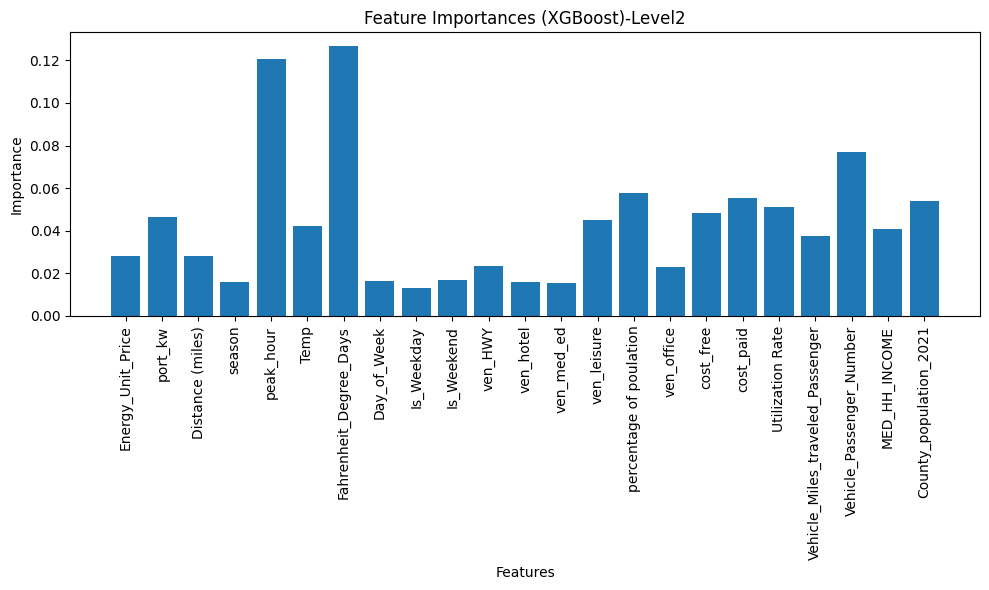

In [67]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search_XG = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_XG.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search_XG.best_params_
best_estimator = grid_search_XG.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate the model on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot feature importances
importances = best_estimator.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (XGBoost)-Level2')
plt.tight_layout()
plt.show()

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.8}
Test MAE: 5.5888
Test R^2: 0.5182


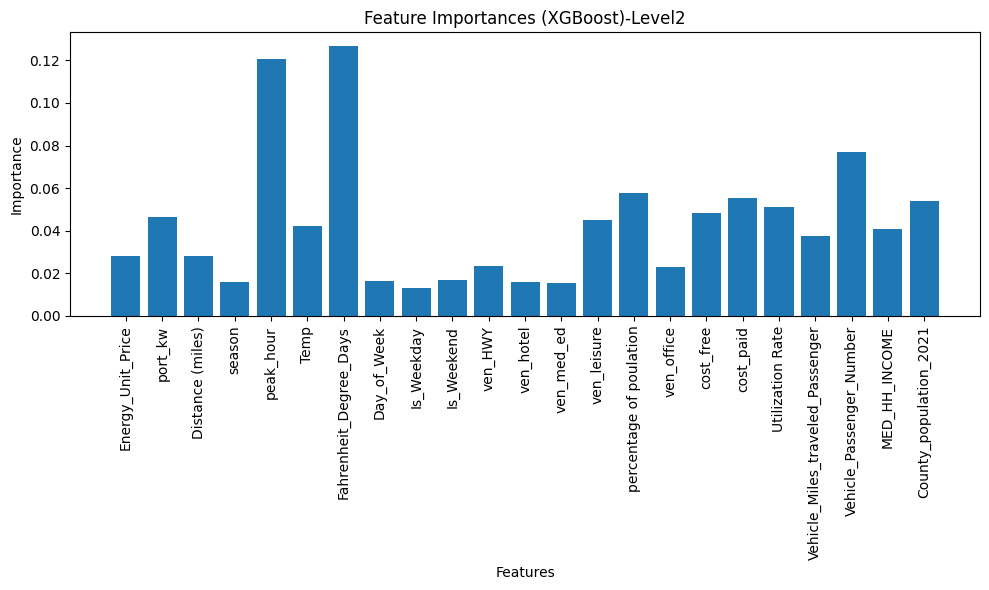

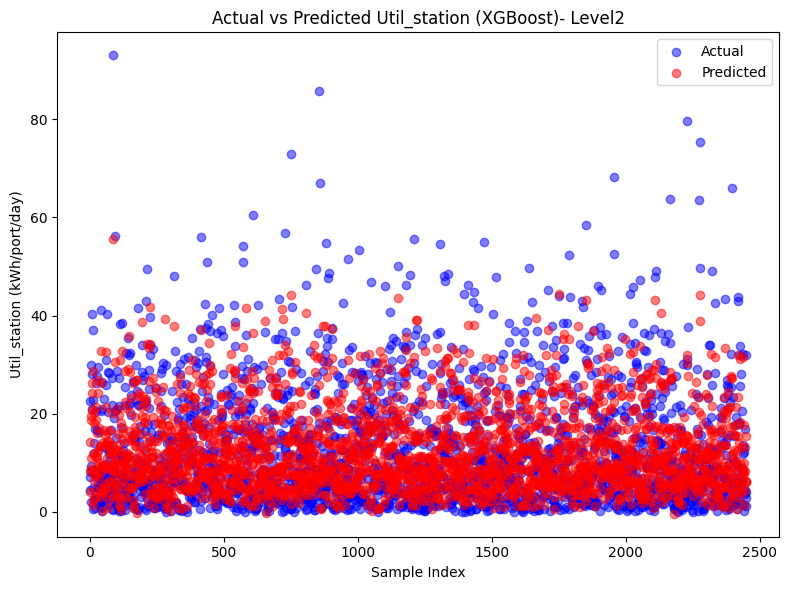

In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search_XG = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_XG.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search_XG.best_params_
best_estimator = grid_search_XG.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate the model on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot feature importances
importances = best_estimator.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (XGBoost)-Level2')
plt.tight_layout()
plt.show()

# Plot actual and predicted values in different colors
plt.figure(figsize=(8, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', alpha=0.5, label='Actual')
plt.scatter(range(len(Y_pred)), Y_pred, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Util_station (kWh/port/day)')
plt.title('Actual vs Predicted Util_station (XGBoost)- Level2')
plt.legend()
plt.tight_layout()
plt.show()

Test MAE: 6.7627
Test R^2: 0.2688


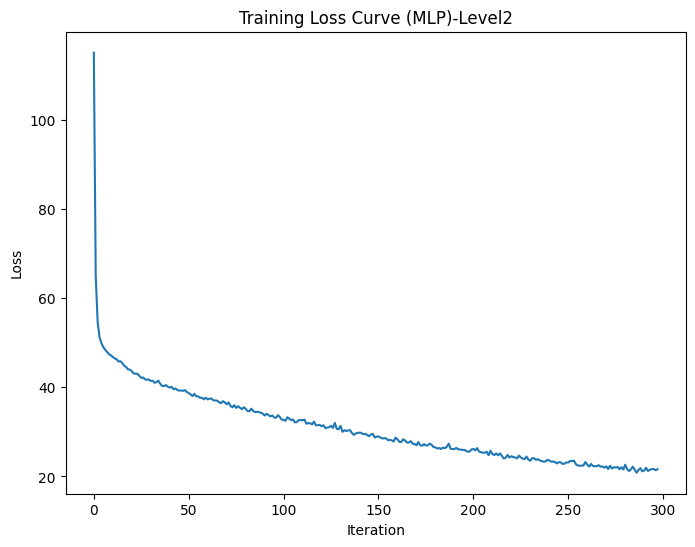

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an MLP regressor
mlp_model = MLPRegressor(hidden_layer_sizes=(200,100, 50), activation='relu', solver='adam',
                         alpha=0.0001, max_iter=1000, random_state=42)

# Train the model
mlp_model.fit(X_train_scaled, Y_train)

# Make predictions on the test set
Y_pred = mlp_model.predict(X_test_scaled)

# Evaluate the model
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot the training loss curve
plt.figure(figsize=(8, 6))
plt.plot(mlp_model.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve (MLP)-Level2')
plt.show()

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 1.0}
Test MAE: 5.5793
Test R^2: 0.5164


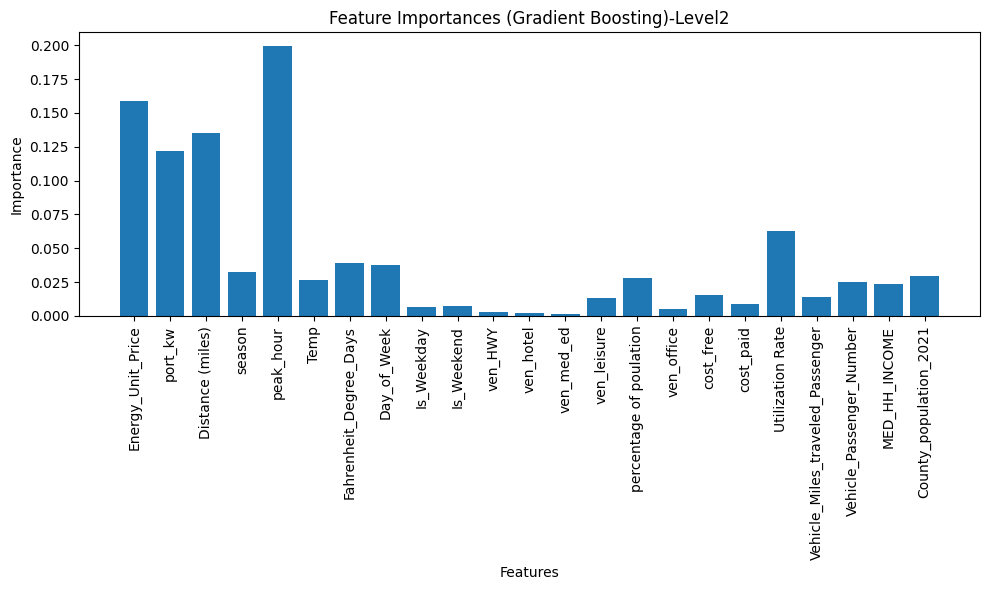

In [70]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

gb_model = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter 
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search_GBR = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_GBR.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search_GBR.best_params_
best_estimator = grid_search_GBR.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate the model on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot feature importances
importances = best_estimator.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (Gradient Boosting)-Level2')
plt.tight_layout()
plt.show()